In [ ]:
import comet_ml 
import torch
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable
from torch.nn.utils import weight_norm
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
import numpy as np



### Simple Net Architecture
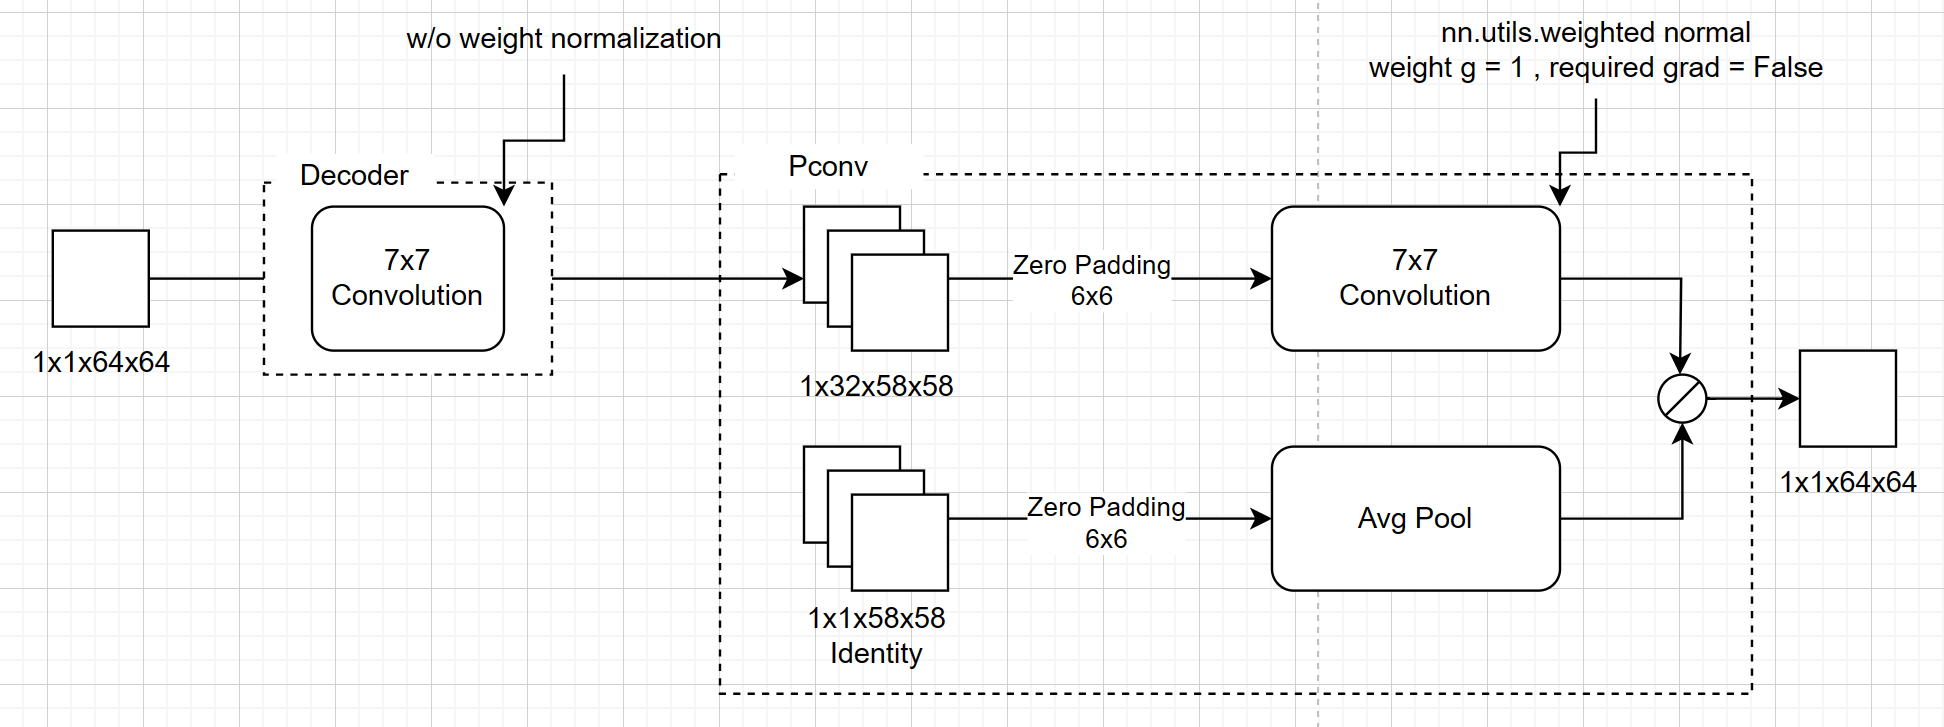

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.krnl_size = 7
        self.decoder = nn.Conv2d(1,128,self.krnl_size,bias=False)
        self.pconv = nn.Conv2d(128,1,self.krnl_size,padding=(6,6),bias=False)
        self.wn_pconv = weight_norm(self.pconv,name='weight')
        self.wn_pconv.weight_g = nn.Parameter(torch.ones_like(self.wn_pconv.weight_g))
        self.wn_pconv.weight_g.requires_grad = False 
        self.avgpool = nn.AvgPool2d(self.krnl_size,stride=1)
        #Partial Convolution Module 
    def forward(self, x, mode = 'train'):
        p = self.krnl_size-1
        x = self.decoder(x)
        latent = x
        n,c,h,w = x.shape
        mask = torch.ones(n,1,h,w).to(x)
        x = self.wn_pconv(x)
        mask = self.avgpool(F.pad(mask,(p,p,p,p)))
        # print(self.wn.weight_g, self.wn.weight_g.requires_grad)
        # return x, latent
        return x/mask, latent

model = SimpleNet()
summary(model, (1,128,128))
# print(model.wn.weight_g, model.wn.weight_g.requires_grad)


### ResNet Architecture
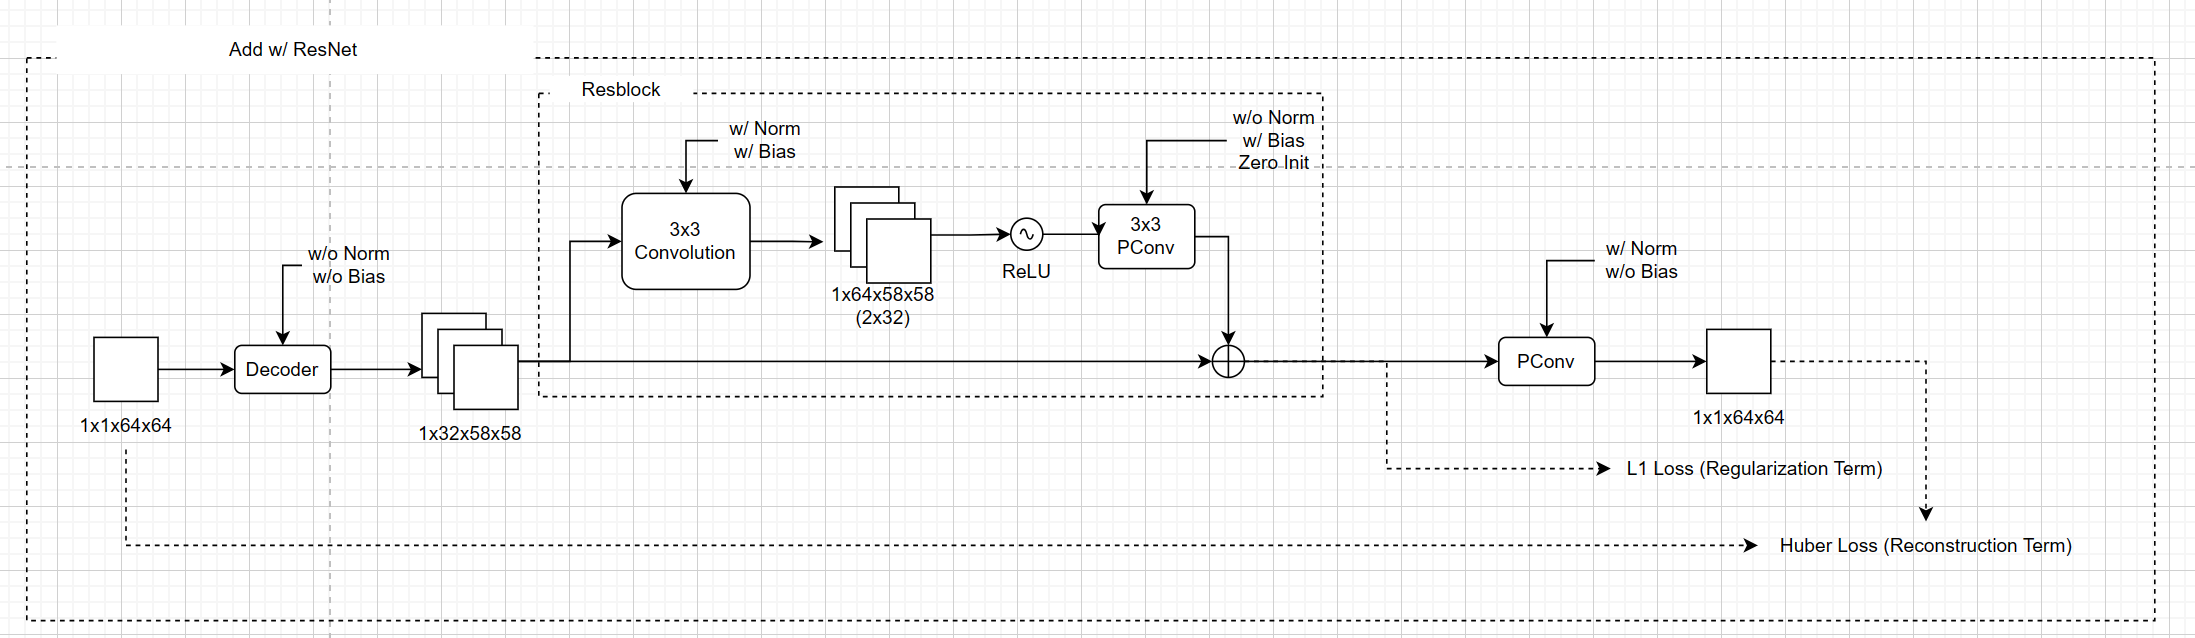

In [ ]:
class ResBlock(nn.Module):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.krnl_size = 3 
        self.pad_size = (self.krnl_size - 1, self.krnl_size - 1)
        self.conv = nn.Conv2d(128,256,self.krnl_size,bias=True)
        self.wn_conv = nn.utils.weight_norm(self.conv,name='weight')
        self.wn_conv.weight_g = nn.Parameter(torch.ones_like(self.wn_conv.weight_g))
        self.wn_conv.weight_g.requires_grad = False 
        self.relu = nn.ReLU()
        self.pconv = nn.Conv2d(256,128,self.krnl_size,padding =self.pad_size,bias=True)
        self.pconv.weight.data.fill_(0) #zero initialization
        self.avgpool = nn.AvgPool2d(self.krnl_size,stride=1)
    def forward(self, x):
        p = self.krnl_size-1
        z  = self.wn_conv(x)
        z = self.relu(z)
        n , _, h, w = z.shape 
        mask = torch.ones(n,1 , h, w).to(z)
        z = self.pconv(z)
        mask = self.avgpool(F.pad(mask,(p, p, p, p)))
        z = z/mask
        return z+x
    
class ResNet(nn.Module):
    def __init__(self, n_res_block) -> None:
        super().__init__()
        self.krnl_size = 7
        self.pad_size = (self.krnl_size-1, self.krnl_size-1)
        self.n_res_block = n_res_block    
        self.decoder = nn.Conv2d(1,128,self.krnl_size,bias=False)
        
        #Residual Part 
        self.res_block = nn.Sequential(*[ResBlock() for _ in range(self.n_res_block)])
        #End of Residual Part
        
        
        self.pconv = nn.Conv2d(128,1,self.krnl_size,padding=self.pad_size,bias=False)
        self.wn_pconv = nn.utils.weight_norm(self.pconv,name='weight')
        self.wn_pconv.weight_g = nn.Parameter(torch.ones_like(self.wn_pconv.weight_g))
        self.wn_pconv.weight_g.requires_grad = False 
        self.avgpool = nn.AvgPool2d(self.krnl_size,stride=1)
        
    def forward(self, x, mode = 'train'):
        x = self.decoder(x)
        p = self.krnl_size-1
        x = self.res_block(x)     
        latent = x
        n,c,h,w = x.shape
        mask = torch.ones(n,1,h,w).to(x)
        x = self.wn_pconv(x)
        mask = self.avgpool(F.pad(mask,(p,p,p,p)))
        # print(self.wn.weight_g, self.wn.weight_g.requires_grad)

        return x/mask , latent


            
    
model = ResNet(n_res_block=3)
summary(model, (1,128,128))
# print(model.wn.weight_g, model.wn.weight_g.requires_grad)


In [ ]:
class RandomTranspose(torch.nn.Module):
    """Transpose the given image randomly with a given probability.
    If the image is torch Tensor, it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading
    dimensions

    Args:
        p (float): probability of the image being transposed. Default value is 0.5
    """

    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be transposed.

        Returns:
            PIL Image or Tensor: Randomly transposed image.
        """
        if torch.rand(1) < self.p:
            return img.transpose(Image.TRANSPOSE)
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

#Example Usage
# image_path = r'Dataset\DIV2K_train_HR_bw\0001.png'
# image = Image.open(image_path)

# transform = RandomTranspose(p=0.5)
# transformed_image = transform(image)
# plt.imshow(transformed_image,cmap='gray')  # Show the transformed image


In [ ]:

train_crop_size = 64
test_crop_size = 256
n_crop = 8
train_data_transform = transforms.Compose([
    transforms.RandomCrop((train_crop_size, train_crop_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    RandomTranspose(p=0.5),
])
test_data_transform = transforms.Compose([
    transforms.CenterCrop((test_crop_size, test_crop_size)),
])


class CustomDataset(Dataset):
    def __init__(self, root_dir, mode = 'train', blur_kernel = None, blur_sigma = None):
        self.root_dir = root_dir
        self.mode = mode
        self.crop_size = train_crop_size
        self.n_crop = n_crop
        if self.mode == 'train':
            self.transform = train_data_transform
        else:
            self.transform = test_data_transform
            
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.blur_transform = transforms.GaussianBlur(blur_kernel,blur_sigma)
        self.toTensor = transforms.ToTensor()

    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)
        if self.mode == 'train':
            images = torch.empty((self.n_crop,1,self.crop_size,self.crop_size))
            blur_images = torch.empty((self.n_crop,1,self.crop_size,self.crop_size))
            for i in range(self.n_crop):
                if self.transform:
                    train_img = self.transform(image)
                    blur_image = self.blur_transform(train_img)
                    images[i] = self.toTensor(train_img)
                    blur_images[i] = self.toTensor(blur_image)
                    
            return images, blur_images
        else :
            test_image = self.transform(image)
            test_blur_image = self.blur_transform(test_image)
            test_image = self.toTensor(test_image)
            test_blur_image = self.toTensor(test_blur_image)
            return test_image,  test_blur_image
    


Sparse Coding's optimization function :
$$ \underset{x_m}{\text{arg min}} \frac{1}{2} \left\| \sum_m d_m \cdot x_m - s \right\|_2^2 + \lambda \sum_m \|x_m\|_1 $$


In [ ]:
class SCLoss(nn.Module):
    def __init__(self, lmbda, delta):
        super(SCLoss, self).__init__()
        self.lmbda = lmbda
        self.delta = delta
    def forward(self, input, target, latent):
        assert input.shape==target.shape
        loss_l2 = 0.5*torch.norm(target-input)**2
        loss_huber = F.huber_loss(input,target,delta=self.delta)
        loss_norm = torch.norm(latent)
        losses = {'Reconstruction':loss_huber, 'Regularization':loss_norm}
        return loss_huber+self.lmbda*loss_norm, losses
        

In [ ]:

# train and test code 
losses = []
recon_losses = []
regu_losses = []
outputs = []
latents = []
def train (model, dataloader, criterion, optimizer, epoch, device, exp):
    counter = 0 
    loss = 0 
    recon_loss = 0
    regu_loss = 0
    output = None 
    latent = None 
    input = None 
    
    for i, (input, input_L) in enumerate(tqdm(dataloader)):
        input = torch.flatten(input,start_dim=0,end_dim=1)
        input_L = torch.flatten(input_L,start_dim=0,end_dim=1)
        input = input.to(device)
        input_L = input_L.to(device)
        input_H = (input-input_L).to(device)
        
        assert len(input.shape) == 4
        optimizer.zero_grad()
        output_H, latent = model(input_H)
        output = output_H+input_L
        # print(f'output_shape:{output.shape}, output_H.range = {output_H.min(), output_H.max()}')
        loss, loss_detail = criterion(output, input, latent)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        recon_loss = loss_detail['Reconstruction'].item()
        regu_loss = loss_detail['Regularization'].item()
        exp.log_metric('InTrain_Loss', loss,step=i,epoch=epoch)
        exp.log_metric('InTrain_Recon_Loss', recon_loss, step=i,epoch=epoch)
        exp.log_metric('InTrain_Regu_Loss', regu_loss, step=i,epoch=epoch)
        if i %10 == 0 :
            input = input.detach().cpu()
            input_L = input_L.detach().cpu()
            input_H = input_H.detach().cpu()
            output = output.detach().cpu()
            output_H = output_H.detach().cpu()
            latent = latent.detach().cpu().squeeze()
            input = F.interpolate(input,scale_factor=4,mode='bicubic')
            input_L = F.interpolate(input_L,scale_factor=4,mode='bicubic')
            input_H = F.interpolate(input_H,scale_factor=4,mode='bicubic')
            output = F.interpolate(output,scale_factor=4,mode='bicubic')
            output_H = F.interpolate(output_H,scale_factor=4,mode='bicubic')
            input_H = (input_H-input_H.min())/(input_H.max()-input_H.min())
            output_H = (output_H-output_H.min())/(output_H.max()-output_H.min())
            exp.log_image(input[0].squeeze().numpy(), image_minmax=(0,1),name=f'train_{i}_target.png', step=epoch)
            exp.log_image(input_L[0].squeeze().numpy(), name=f'train_{i}_input_L.png', step=epoch)
            exp.log_image(input_H[0].squeeze().numpy(), name=f'train_{i}_input_H.png', step=epoch)
            exp.log_image(output[0].squeeze().numpy(), image_minmax=(0,1), name=f'train_{i}_output.png', step=epoch )
            exp.log_image(output_H[0].squeeze().numpy(), name=f'train_{i}_output_H.png', step=epoch )
    exp.log_metric('Train_Loss', loss,step=epoch)
    exp.log_metric('Train_Recon_Loss', recon_loss,step=epoch)
    exp.log_metric('Train_Regu_Loss', regu_loss,step=epoch)
    

    
    return loss, loss_detail


def test(model, dataloader, criterion, device, epoch, exp, output_dir = 'result'):
    s_loss = []
    s_recon_loss = [] 
    s_regu_loss = []
    save_list = [1,20,22,26,28,54,61,72,93,95,97,99]
    for i, (input, input_L) in enumerate(tqdm(dataloader)):
        input = input.to(device)
        input_L = input_L.to(device)
        input_H = (input-input_L).to(device)
        assert len(input.shape) == 4
        output_H, latent = model(input_H)
        output = output_H+ input_L
        loss, loss_detail = criterion(input_L, input, latent)
        # loss, loss_detail = criterion(output, input, latent)
        
        input = input.detach().cpu()
        input_L = input_L.detach().cpu()
        input_H = input_H.detach().cpu()
        output = output.detach().cpu()
        output_H = output_H.detach().cpu()
        latent = latent.detach().cpu().squeeze()
        # print(latent.shape)
        input = F.interpolate(input,scale_factor=4,mode='bicubic')
        input_L = F.interpolate(input_L,scale_factor=4,mode='bicubic')
        input_H = F.interpolate(input_H,scale_factor=4,mode='bicubic')
        output = F.interpolate(output,scale_factor=4,mode='bicubic')
        output_H = F.interpolate(output_H,scale_factor=4,mode='bicubic')
        # latent = F.interpolate(latent,scale_factor=2,mode='bicubic')
        
        
        if i in save_list:
            n_display = 16
            n_row = 4
            kernel = model.wn_pconv.weight_v.cpu().detach().numpy()[0]
            
            input_H = (input_H+input_H.min())/(input_H.max()-input_H.min())
            output_H = (output_H+output_H.min())/(output_H.max()-output_H.min())
            exp.log_image(input.squeeze().numpy(), image_minmax=(0,1),name=f'test_{i}_target.png', step=epoch)
            exp.log_image(input_L.squeeze().numpy(), name=f'test_{i}_input_L.png', step=epoch)
            exp.log_image(input_H.squeeze().numpy(),  name=f'test_{i}_input_H.png', step=epoch)
            exp.log_image(output.squeeze().numpy(), image_minmax=(0,1), name=f'test_{i}_output.png', step=epoch )
            exp.log_image(output_H.squeeze().numpy(), name=f'test_{i}_output_H.png', step=epoch )
            
            fig, axes = plt.subplots(1,2, figsize=(10,5))
            axes[0].imshow(input.squeeze().numpy(), cmap='gray')  
            axes[1].imshow(output.squeeze().numpy(), cmap='gray')  
            axes[0].set_title('Input/Target')
            axes[1].set_title('Output')
            axes[0].axis('off')
            axes[1].axis('off')
            plt.subplots_adjust(wspace=0.2, hspace=0.2)
            plt.tight_layout()
            plt.savefig(f'{output_dir}/Test_Image_{i}.png')
            
            #plot the feature maps
            fig, axes = plt.subplots(n_row, n_display//n_row, figsize=(n_row, n_display//n_row))
            for j, ax in enumerate(axes.flat):
                ax.imshow(latent[j], cmap='gray')  # Display the image
                ax.axis('off')  # Hide the axis 
            plt.subplots_adjust(wspace=0.2, hspace=0.2)
            plt.tight_layout()
            plt.savefig(f'{output_dir}/feature_map_{i}.png')
            exp.log_image(f'{output_dir}/feature_map_{i}.png',name =f'test_{i}_feature', step=epoch)
            
            #plot feature maps 
            
        s_loss.append(loss.item())
        s_recon_loss.append(loss_detail['Reconstruction'].item())
        s_regu_loss.append(loss_detail['Regularization'].item())


    kernel = model.wn_pconv.weight_v.cpu().detach().numpy()[0]
    # plot kernel
    fig, axes = plt.subplots(n_row, n_display//n_row, figsize=(n_row, n_display//n_row))
    # Loop through the grid and plot each image
    for i, ax in enumerate(axes.flat):
        ax.imshow(kernel[i], cmap='gray')  # Display the image
        ax.axis('off')  # Hide the axis 
    # Adjust layout with some gap
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    # Show the plot
    plt.savefig(f'{output_dir}/kernel_{epoch}.png')
    exp.log_image(f'{output_dir}/kernel_{epoch}.png',name =f'kernel.png', step=epoch)

    
    exp.log_metric('Test_Loss', np.mean(s_loss),step=epoch)
    exp.log_metric('Test_Recon_Loss', np.mean(s_recon_loss),step=epoch)
    exp.log_metric('Test_Regu_Loss', np.mean(s_regu_loss),step=epoch)
                    
    print(f"Test Epoch {epoch+1}, Loss: {np.mean(s_loss):.4f}, Recon_Loss: {np.mean(s_recon_loss):.4f}, Regu_Loss: {np.mean(s_regu_loss):.4f}")



In [ ]:
def find_latest_checkpoint(checkpoint_dir):
    # List all files in the checkpoint directory
    all_files = os.listdir(checkpoint_dir)
    
    # Filter out files that do not match the checkpoint naming convention
    checkpoint_files = [f for f in all_files if f.endswith('.pth')]
    
    if not checkpoint_files:
        return None
    
    # Sort the checkpoint files based on modification time
    checkpoint_files.sort(key=lambda x: os.path.getmtime(os.path.join(checkpoint_dir, x)), reverse=True)
    
    # The latest checkpoint file is the first one in the sorted list
    latest_checkpoint = checkpoint_files[0]
    return os.path.join(checkpoint_dir, latest_checkpoint)

def load_checkpoint(model, optimizer, checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    
    # Load model state dictionary
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load optimizer state dictionary
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Load other training parameters
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    recon_losses = checkpoint['recon_losses']
    regu_losses = checkpoint['regu_losses']
    print(f'load from checkpoint: {epoch}') 

    return model, optimizer, epoch, loss, recon_losses, regu_losses

In [ ]:
#hyperparams 
hyperparams = {
    'model_name' : 'ResNet',
    'epoch' : 75, 
    'lmbda' : 5e-4, 
    'delta' : 0.04,
    'blur_kernel' : 7, 
    'blur_sigma': 7, 
    'lr' : 1e-4, 
    'n_res_block' : 34,
    'ExperimentName': 'DIV2K',
    'load_checkpoint' : True,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Train on {device}')

train_set = CustomDataset(root_dir=r'Dataset\DIV2K_train_HR_bw', mode = 'train', blur_kernel = hyperparams['blur_kernel'], blur_sigma = hyperparams['blur_sigma'])
train_dataloader = DataLoader(train_set, batch_size=4, shuffle=True)
test_set = CustomDataset(root_dir=r'Dataset\DIV2K_valid_HR_bw',  mode = 'test', blur_kernel = hyperparams['blur_kernel'], blur_sigma = hyperparams['blur_sigma'])
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False)

folder_name = f'checkpoints/lambda_{hyperparams["lmbda"]}_delta_{hyperparams["delta"]}_gaussian_{hyperparams["blur_kernel"]}_{hyperparams["blur_sigma"]}'
if not os.path.exists(folder_name):
    os.mkdir(folder_name)

if hyperparams['model_name'] == 'ResNet' :
    model = ResNet(n_res_block=hyperparams['n_res_block']).to(device)
elif hyperparams['model_name'] == 'SimpleNet':
    model = SimpleNet().to(device)
    
# Define loss function and optimizer
criterion = SCLoss(lmbda=hyperparams['lmbda'], delta = hyperparams['delta'])
optimizer = optim.Adam(model.parameters(), lr = hyperparams['lr'])

# init comet 
comet_ml.init()
exp = comet_ml.Experiment(api_key='NGgjeGxw7n1xPCoFUz4XUU4Zv',project_name = 'partialconv')
exp.log_parameters(hyperparams)
exp.set_model_graph(model)
exp.log_code('PartialNet.ipynb')

last_epoch = 0
#train and testing 
if load_checkpoint:
    checkpoint_dir = f'{folder_name}'
    latest_checkpoint_path = find_latest_checkpoint(checkpoint_dir)
    if latest_checkpoint_path is not None:
        model, optimizer, last_epoch, loss, recon_losses, regu_losses = load_checkpoint(model, optimizer, latest_checkpoint_path)
    else :
        print('no checkpoint found')

test_result_path = os.path.join(folder_name, 'result')
test(model,test_dataloader,criterion,device,last_epoch,exp, test_result_path)

for epoch in range(last_epoch, hyperparams['epoch']):
    try:
        test_result_path = os.path.join(folder_name, 'result')
        if not os.path.exists(test_result_path):
            os.mkdir(test_result_path)
        train_loss, train_loss_detail = train(model,train_dataloader,criterion,optimizer,epoch,device,exp)
        if epoch %5 == 0 :
            test(model,test_dataloader,criterion,device,epoch,exp, test_result_path)
            if epoch % 10 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': train_loss,
                    'recon_losses': train_loss_detail['Reconstruction'],
                    'regu_losses': train_loss_detail['Regularization'],            
                    }, f'{folder_name}/{epoch}.pth')
    except KeyboardInterrupt:
        exp.end()
        break 
exp.end()